# Week 04a Assignment weather data

Welcome to week four of this course programming 1. Analyzing time related data such as estimating seasonal effect, or year effect might be a challenge. How to filter the essential information from the noise? How to apply signal analysis with noisy data. How to make compact useful visualizations? Python has several constructs to handle date time related data. The relevant classes for making plots are Locators and Formatters. Locators determine where the ticks are, and formatters control the formatting of tick labels. The relevant class for date time data is the pandas datetime data type, which has methods like resample and several possibilities to display data (frequencies). As a study case we will work with weather data. If you have data that fits the learning goals, you can bring your own data.

Keywords: signal processing, smoothing, resample, formatters and locators, datetime object

More to read: 

- https://fennaf.gitbook.io/bfvm22prog1/
- https://machinelearningmastery.com/time-series-data-visualization-with-python/
- https://towardsdatascience.com/how-to-plot-time-series-86b5358197d6
- In the https://pandas.pydata.org/docs/reference/offset_frequency.html you can find more about frequencies and in the documentation
- https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html you can read all the methods of this datetime object.
- https://en.wikipedia.org/wiki/Smoothing


Learning objectives

- load, inspect and clean a dataset
- reshape dataframes to group data in a certain frequency
- apply smoothing technologies
- Create useful visualisation with timeseries data
- Maintain development environment 
- Apply coding standards and FAIR principles

Please add topics you want to learn here: https://padlet.com/ffeenstra1/z9duo25d39dcgezz


## Assignment

You will to organise your data into the required format and apply smoothing. In this assignment we will work with weatherdata from the KNMI. A subset of weatherdata is for you available in the file: `KNMI_20181231`. The data consist of several stations with daily weather data of several years. Your task is to make a plot similar to the plot below. 

<img src="../images/weather.png" alt="drawing" width="400"/>


Furthermore the plot needs the following enhancements

1. proper titles and ticks
2. widgets selecting a particular year or all years
3. lines need to be smoothed
3. legends needs to be added

Use your creativity. Consider colors, alpha settings, sizes etc. 

Learning outcomes

- load, inspect and clean a dataset 
- reformat dataframes
- apply smoothing technologies
- visualize timeseries data

The assignment consists of 6 parts:

- [part 1: load the data](#0)
- [part 2: clean the data](#1)
- [part 3: reformat data](#2)
- [part 4: smooth the data](#3)
- [part 5: visualize the data](#4)
- [part 6: Challenge](#5)

Part 1 and 5 are mandatory, part 6 is optional (bonus)
Mind you that you cannot copy code without referencing the code. If you copy code you need to be able to explain your code verbally and you will not get the full score. 


NB if you want to make a plot with more actual data you can download data from https://openweathermap.org/api 


---

<a name='0'></a>
## Part 1: Load the data

Either load the dataset `KNMI_20181231.csv` or `KNMI_20181231.txt.tsv`. 
Preferably we read the data not with a hard coded data path but using a config file. See https://fennaf.gitbook.io/bfvm22prog1/data-processing/configuration-files/yaml. The dataheaders contain spaces and are not very self explainable. Change this into more readable ones. Select data from a station. Station 270 is in the neighborhood of Groningen. For our plot we only need the the mean, minimum and maximum temperature. Of course you are welcome to select other data if you think it might be useful for your visualization. The data should look something like this:


In [189]:
import yaml

def get_config():
    """ function that fetches the configuration 
    parameters from config.yaml"""
    with open("./config.yaml", 'r') as stream:
        config = yaml.safe_load(stream)
    return config

config = get_config()
knmi = config['knmi_data']

In [190]:
import pandas as pd

df = pd.read_csv(knmi, comment='#', header=None,
                 dtype={2:'str', 3: 'str', 4:'str', 5: 'str', 6: 'str'},  # string datatype so we can remove NaN's later on
                 names=['station','Date', 'Tmean', 'Tmin', 'Tmax', 'SQ', 'DR', 'RH'])

---

<a name='1'></a>
## Part 2: Clean the data

The data ia not clean. There are empty cells in the dataframe which needs to be replaced with NaN's and the temperature is in centidegrees which needs to be transformed into degrees. The date field needs a datetime format. For visualization convience we would like to remove the leap year. Conduct the cleaning.

In [191]:
import numpy as np

# replace cells with spaces to NaN
df = df.replace(r'^\s*$', np.nan, regex=True)

# select relevant columns
df = df.iloc[:,0:5]

# change data formats
df.Date = pd.to_datetime(df.Date, format='%Y%m%d')
df.Tmean = pd.to_numeric(df.Tmean, errors='coerce')
df.Tmin = pd.to_numeric(df.Tmin, errors='coerce')
df.Tmax = pd.to_numeric(df.Tmax, errors='coerce')

# change temperatures to degrees
df.Tmean = df.Tmean / 10
df.Tmin = df.Tmin / 10
df.Tmax = df.Tmax / 10

# remove leap year
df = df[~df.Date.dt.is_leap_year]
df_all = df.copy()  # used later in the (bonus) assignment to get all the data

# select station
df = df[df.station == 270]

To see the distribution and to check for possible outliers boxplots were made of the Tmin, Tmean and Tmax data.

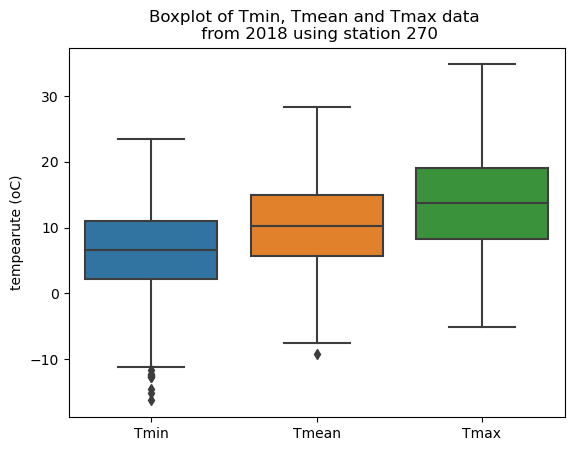

In [192]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = sns.boxplot(data=[df.Tmin, df.Tmean, df.Tmax])
fig.set_xticklabels(['Tmin', 'Tmean', 'Tmax'])
fig.set_ylabel('tempearute (oC)')
fig.set_title('Boxplot of Tmin, Tmean and Tmax data \n from 2018 using station 270')
plt.show(fig)

As can be seen all of the data have a nice distribution. Furthermore, the Tmean is inbetween the Tmin and Tmax which makes sense. However, Tmin shows a few outliers and Tmean shows one outlier. Before using this dataset these outliers need to be removed. This is done be replacing the value by a NaN so that the instead of removing the whole row. Other data in that row is still valid and needs to stay.

In [193]:
from scipy import stats

# the outliers are removed using zscores which are below the threshold
df.Tmin = df.Tmin[(np.abs(stats.zscore(df.Tmin)) < 3)]
df.Tmean = df.Tmean[(np.abs(stats.zscore(df.Tmean)) < 3)]

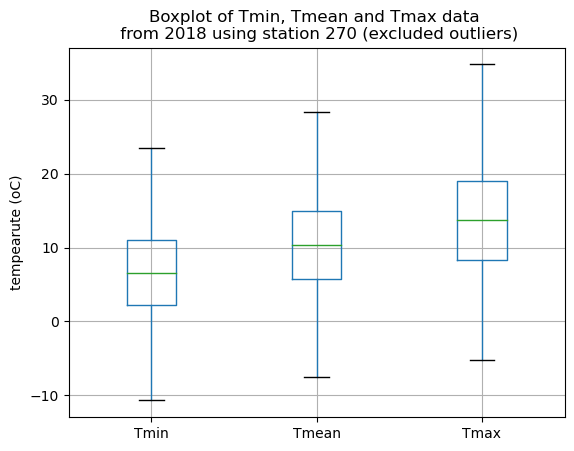

In [194]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = df.boxplot(column=['Tmin', 'Tmean', 'Tmax'])
fig.set_xticklabels(['Tmin', 'Tmean', 'Tmax'])
fig.set_ylabel('tempearute (oC)')
fig.set_title('Boxplot of Tmin, Tmean and Tmax data \n from 2018 using station 270 (excluded outliers)')
plt.show(fig)

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>pd.to_datetime(df['Date'].astype(str), format='%Y%m%d')</li>
    <li>regex for empty cells = `^\s*$` </li>
    <li>remove month == 2 & day == 29</li> 
</ul>
</details>

In [195]:
#Test your outcome
#write code to check if you have done the above
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 98007 to 104580
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   station  5110 non-null   int64         
 1   Date     5110 non-null   datetime64[ns]
 2   Tmean    5109 non-null   float64       
 3   Tmin     5100 non-null   float64       
 4   Tmax     5110 non-null   float64       
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 239.5 KB
None


The expected outcome is different than my results. This is because a different file was used to obtain the expected outcome. The DateTimeIndex goes from 1951 to 2018, while my results go from 2000 to 2018. So eventhough it is not the same, you would expect that there are more entries in the expected outcome when compared to mine. This is the case and all the column and their datatypes are the same. For these reasons I am assuming my data is correct and continueing with this dataframe.

### Expected outcome

---

<a name='2'></a>
## Part 3: Reform your data

First we will split the data in data from 2018 and data before 2018. Best is to split this in two dataframes. 
Next we need for the non 2018 data the minimum values for each day and the maximum values for each day. So we look for the minimum value out of all january-01 minimum values (regardless the year). Create a dataframe with 365 days containing the ultimate minimum and the ultimate maximum per day. 


In [196]:
def month_day(df_multipleyears):
    #your code to reform data here
    df_groupedbymonthday = df_multipleyears.groupby([df_multipleyears.Date.dt.month.rename('month'), df_multipleyears.Date.dt.day.rename('day')]).Tmin.min()    
    print(df_groupedbymonthday)

In [197]:
#Test your code
def test_reformed(df):
    df = df[(df.Date.dt.year > 2007) & (df.Date.dt.year < 2018)]
    month_day(df)

test_reformed(df)

month  day
1      1     -5.8
       2     -7.5
       3     -2.2
       4     -4.1
       5     -6.0
             ... 
12     27    -2.0
       28    -4.2
       29    -5.0
       30    -6.7
       31     0.2
Name: Tmin, Length: 365, dtype: float64


Again, my outcome is different than the expected outcome due to a different dataset being used. However, some of the outcomes are the same this is probably due to the fact that the ultimate minimum of all of the years is between 2000 and 2018. This somewhat confirms that my method was correct

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use the dt.month and dt.day to groupby</li>
</ul>
</details>

### Expected outcome
Note, the layout or names my differ, but the length should be 365 and the minimum values should be the same

---

<a name='3'></a>
## Part 4: Smooth the data

Make a function that takes an array or a dataframe column and returns an array of smoothed data. Explain in words why you choose a certain smoothing algoritm. Ask the signal analysis teacher if you want some advice.


To smooth the data I used a rolling mean. I had diffucilty in finding/choosing a smoothing method. I found a method that smoothes the data using the rolling function, after which a sum was applied (https://medium.com/@teamastertoast/smoothing-time-series-in-python-a-walkthrough-with-covid-19-data-b4ccfb980a61). I tried this method at first, but it was given me higher results (of course) because it was summing all the data point in the rolling window. From a previous exercise I knew you could also apply the mean function after a rolling function. I tried it and it gave met quite smooth and promising results. I tried different values for the rolling window and found 7 to be the best.

In [198]:
#your code here
def smooth_data(df_column):
    return df_column.rolling(7).mean()

df['smooth'] = smooth_data(df.Tmean)

---

<a name='4'></a>
## Part 5: Visualize the data

Plot the mean temperature of the year 2018. Create a shaded band with the ultimate minimum values and the ultimate maximum values from the multi-year dataset. Add labels, titles and legends. Use proper ranges. Be creative to make the plot attractive. 



In [178]:
# get the data we want to plot
df_ultimates = df.groupby([df.Date.dt.month.rename('month'), df.Date.dt.day.rename('day')]).agg({'Tmin': 'min', 'Tmax': 'max', 'Tmean': 'mean'})
df_2018 = df[df.Date.dt.year == 2018]

In [179]:
# we need to have the same index in both dfs so that we can use that as plotting, we set the day count (1 to 365) as index and use it as the x value in plotting
df_2018.index = range(1, len(df_2018)+1)
df_ultimates = df_ultimates.reset_index()
df_ultimates.index = range(1, len(df_ultimates)+1)

In [202]:
#CODE YOUR SOLUTION HERE
from bokeh.io import show, output_notebook
from bokeh.models import ColumnDataSource, Select, Band, DataRange1d, Range1d, DatetimeTickFormatter
from bokeh.plotting import figure

output_notebook()

# create figure
p = figure(width=800, height=500,
           title='Weatherdata of 2018 using station 270\n',
            x_axis_label='Date',
            x_axis_type='datetime',
            y_axis_label='Temperatue (oC)')

# create line of the smoothed 2018 Tmean data
p.line(x=df_2018.index,
       y=df_2018.smooth,
       legend_label='smoothed mean temperature')

# create the bands with the ultimate min and max of each day
band_source = ColumnDataSource({'tmin': df_ultimates.Tmin, 
                                'tmax': df_ultimates.Tmax, 
                                'x'   : df_ultimates.index})
band = Band(base='x', lower='tmin', upper='tmax', source=band_source,
            fill_alpha=0.3, fill_color="gray", line_color="black")
p.add_layout(band)

# set ranges for x and y so that everything is visible (zoom of the plot)
p.x_range = DataRange1d(range_padding=0.0)
p.y_range = Range1d(df_ultimates.Tmin.min(), df_ultimates.Tmax.max())

############################################################################################################
# I had difficulty changing the x-axis to the date using a formatter, that is why I did it manually.       #
# What it does is it sets the x-axis ticks manually and then changes these ticks according to a dictionary #
# where the keys are the manually set ticks and the values the new tick names. This led to another problem #
# cause it was a datetime object, that is why I converted it to a str and extracted the date using split   #
############################################################################################################

# create x-axis ticks
ticks = [i for i in range(1, 366, 10)]
p.xaxis.ticker = ticks
p.xaxis.major_label_overrides = {t:str(df_2018.Date[df_2018.index == t]).split()[1] for t in ticks}
p.xaxis.major_label_orientation = "vertical"

# show the plot
show(p)

Loading BokehJS ...

<details>    
<summary>
    <font size="3" color="darkgreen"><b>Hints</b></font>
</summary>
<ul><li>use from bokeh.models import Band</li>
    <li>use ColumnDataSource to parse data arrays</li>
    <li>look for xaxis tick formatters</li>
</ul>
</details>

---

<a name='5'></a>
## Part 6: Challenge

Make a widget in which you can select the year range for the multiyear set. Or maybe a widget were you choose a different station. Add this to your layout to make the plot interactive. Add another widget to select or deselect the smoother. Inspiration: https://demo.bokeh.org/weather

In [203]:
def get_dfs(df, station, year):
    """creates a df with the right station and years, also creates the df with ultimate values"""
    # we need to have the same index in both dfs so that we can use that as plotting
    # we set the day count (1 to 365) as index and use it as the x value in plotting later
    
    # extract data
    df_year = df[(df.station == station) & (df.Date.dt.year == year)]
    # set right index
    df_year.index = range(1, len(df_2018)+1)
    
    # get ultimate data
    df_ultimates = df.groupby([df.Date.dt.month.rename('month'), df.Date.dt.day.rename('day')]).agg({'Tmin': 'min', 'Tmax': 'max', 'Tmean': 'mean'})
    # set right index
    df_ultimates = df_ultimates.reset_index()
    df_ultimates.index = range(1, len(df_ultimates)+1)
    
    return df_year, df_ultimates


def smooth_data(df_column):
    """smooths the data using a rolling mean"""
    return df_column.rolling(7).mean()


def render_plot(station=270, year=2018, smoothing=True):
    """Function to render a bokeh plot"""
    # get smoothed the data if True
    if smoothing == 'True':
        df_all['smooth'] = smooth_data(df_all.Tmean)   
    
    # Some combinations give back a value error if the combination does not exist in the df
    try:
        df_year, df_ultimates = get_dfs(df_all, station, year)
    except ValueError:
        return 'Missing data, try another combination :)'
    
    # later we need at least two points to plot a line
    if df_year.Tmean.notna().sum() < 2:
        return 'Missing data, try another combination :)'
    
    # create figure
    p = figure(width=1000, height=700,
        title=f'Weatherdata of {year}\n',
            x_axis_label='Date',
            y_axis_label='Temperatue (oC)')
    
    # create band
    band_source = ColumnDataSource({'tmin': df_ultimates.Tmin, 
                                    'tmax': df_ultimates.Tmax, 
                                    'x'   : df_ultimates.index})
    band = Band(base='x', lower='tmin', upper='tmax', source=band_source,
            fill_alpha=0.3, fill_color="lightblue", line_color="black")
    
    # create line
    
    if smoothing == 'True':
        p.line(x=df_year.index, y=df_year.smooth, legend_label=f'smoothed mean temperature in {year}')
    else:
        p.line(x=df_year.index, y=df_year.Tmean, legend_label=f'mean temperature in {year}')

    # set range/zoom of the plot
    p.x_range = DataRange1d(range_padding=0.0)
    p.y_range = Range1d(df_ultimates.Tmin.min(), df_ultimates.Tmax.max())
    p.add_layout(band) 
    
    # manually change tick names
    ticks = [i for i in range(1, 366, 13)]
    p.xaxis.ticker = ticks
    p.xaxis.major_label_overrides = {tick: str(df_year.Date[df_year.index == tick]).split()[1] for tick in ticks}
    p.xaxis.major_label_orientation = "vertical" 

    return p



In [204]:
import panel as pn
pn.extension()
from bokeh.models import Dropdown

menu = [("Item 1", "item_1"), ("Item 2", "item_2"), None, ("Item 3", "item_3")]
dropdown = Dropdown(label="Dropdown button", button_type="warning", menu=menu)

# create widgets
inter_methods = pn.interact(render_plot, 
                            station=list(df_all.station.unique()),
                            year=[y for y in range(2000, 2019)], 
                            smoothing=['True', 'False'])

# create dashboard and add widgets
dashboard = pn.template.BootstrapTemplate(title='Weather data', sidebar_width=350, 
                                          theme = pn.template.theme.DarkTheme)
dashboard.sidebar.append(inter_methods[0])
dashboard.main.append(inter_methods[1])

# show dashboard
dashboard.show()

Launching server at http://localhost:45101
